In [1]:
!gdown --id 1D5PQbbm9UMXd4V4e-Nj4Uq9ncqGvDI00

Downloading...
From: https://drive.google.com/uc?id=1D5PQbbm9UMXd4V4e-Nj4Uq9ncqGvDI00
To: /content/task3_dataset.zip
100% 11.7M/11.7M [00:00<00:00, 25.4MB/s]


In [2]:
!unzip -q -o task3_dataset.zip

In [3]:
import os
import glob
import itertools

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
from torchvision import transforms, models

torch.cuda.is_available()

True

In [4]:
action_to_id_map = {
    "bored": 0,
    "covering": 1,
    "dreaming": 2,
    "sleeping": 3,
}

id_to_action_map = {
    0: "bored",
    1: "covering",
    2: "dreaming",
    3: "sleeping",
}

def get_image_paths(data_dir="./data_v3", val_seq=["seq11", "seq12", "seq13"]):
    train, test = [], []
    seqs = glob.glob(os.path.join(data_dir, "seq*"))
    for seq in seqs:
        seq_name = os.path.basename(seq)
        actions = glob.glob(os.path.join(seq, "*"))
        for action in actions:
            label_name = os.path.basename(action)
            label_id = action_to_id_map[label_name]
            imgs = glob.glob(os.path.join(action, "*"))
            for img_name in imgs:
                if seq_name in val_seq:
                    test.append((img_name, label_id))
                else:
                    train.append((img_name, label_id))

    return train, test

train, test = get_image_paths()
train[0], test[0]

(('./data_v3/seq8/covering/IMG_20220211_203334.jpg', 1),
 ('./data_v3/seq13/covering/IMG_20220211_204357.jpg', 1))

In [5]:
def plot_distribution_of_data(df, title=""):
    activity, counts = np.unique(df.activity_name, return_counts=True)
    index = np.arange(len(activity))
    plt.figure(figsize=(12, 5))
    plt.bar(index, counts, align = 'center', alpha=0.5, color='lightblue')
    plt.suptitle(title, fontsize=16)
    plt.xticks(index, activity, rotation=90, fontsize=8)
    plt.xlim([-.5, 3.5])
    plt.ylabel('frequency', fontsize=10)
    for i, v in enumerate(counts):
        plt.text(i, v, str(v), color='grey', fontweight='bold')
    plt.show()

In [6]:
df = pd.DataFrame(train + test)
df.columns = ["img_path", "activity_name"]
df["activity_name"] = df["activity_name"].map(id_to_action_map)
df.head()

,img_path,activity_name
0,./data_v3/seq8/covering/IMG_20220211_203334.jpg,covering
1,./data_v3/seq8/covering/IMG_20220211_203339.jpg,covering
2,./data_v3/seq8/covering/IMG_20220211_203347.jpg,covering
3,./data_v3/seq8/covering/IMG_20220211_203343.jpg,covering
4,./data_v3/seq8/covering/IMG_20220211_203351.jpg,covering


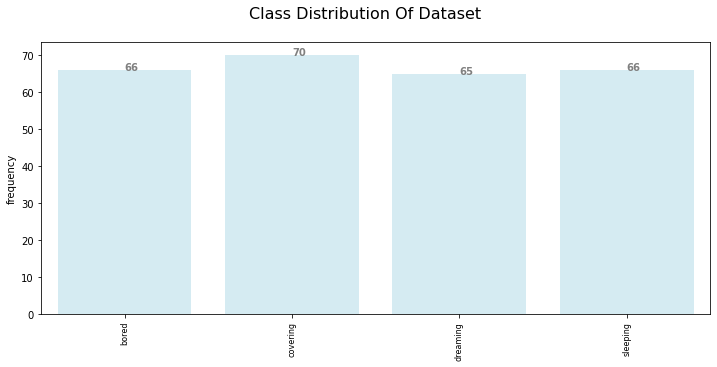

In [7]:
plot_distribution_of_data(df, title='Class Distribution Of Dataset')

In [8]:
def trainer(model, optimizer, criterion, train_loader, test_loader, model_name="cnn_model.pth", epochs=150):
    if torch.cuda.is_available():
      model.to("cuda")
    
    train_accs = []
    test_accs = []
    train_losses = []
    test_losses = []
    best_accuracy = 0
    for epoch in range(epochs):
        train_loss = 0.0
        test_loss = 0.0
        total = 0
        correct = 0
        model.train()
        for step, (batch_image, batch_label) in enumerate(tqdm(train_loader)):
            if torch.cuda.is_available():
                batch_image, batch_label = batch_image.to("cuda"), batch_label.to("cuda")
            batch_output = model(batch_image)
            batch_loss = criterion(batch_output, batch_label)

            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            train_loss += batch_loss.item()

            # train accuracy
            _, train_predicted = torch.max(batch_output.data, 1)
            total += batch_label.size(0)
            correct += (train_predicted == batch_label).sum().item()

        train_acc = correct / total

        # ----------test----------
        total = 0
        correct = 0
        model.eval()
        with torch.no_grad():
          test_acc = 0.0
          for test_image, test_label in tqdm(test_loader):
              if torch.cuda.is_available():
                  test_image, test_label = test_image.to("cuda"), test_label.to("cuda")
              test_output = model(test_image)
              batch_loss = criterion(test_output, test_label)
              test_loss += batch_loss.item()

              _, predicted = torch.max(test_output.data, 1)
              total += test_label.size(0)
              correct += (predicted == test_label).sum().item()
        test_acc = correct / total

        print('epoch={:d} train loss={:.6f} test loss={:.6f} train accuracy={:.3f} test accuracy={:.3f}'.format(
            epoch, train_loss / (step+1), test_loss / (step + 1), train_acc, test_acc)
        )
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        train_losses.append(train_loss / (step+1))
        test_losses.append(test_loss / (step + 1))

        if test_acc > best_accuracy:
            torch.save(model.state_dict(), model_name)
            best_accuracy = test_acc
    return train_losses, test_losses, train_accs, test_accs

In [9]:
def tester(model, test_loader):
    if torch.cuda.is_available():
      model.to("cuda")
      
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
      for test_image, test_label in test_loader:
          if torch.cuda.is_available():
              test_image, test_label = test_image.to("cuda"), test_label.to("cuda")
          test_output = model(test_image)
          _, predicted = torch.max(test_output.data, 1)

          y_true.extend(list(test_label.cpu().numpy()))
          y_pred.extend(list(predicted.cpu().numpy()))
    return y_true, y_pred

In [10]:
def plot_accuracy_per_epoch(train_accuracies, valid_accuracies):
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1,len(valid_accuracies)+1), valid_accuracies,label='Valid Accuracy')

    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.ylim(0, 1.1) # consistent scale
    plt.xlim(0, len(train_accuracies)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_avg_loss_per_epoch(avg_train_losses, avg_valid_losses):
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(avg_train_losses)+1), avg_train_losses, label='Training Loss')
    plt.plot(range(1,len(avg_valid_losses)+1), avg_valid_losses,label='Validation Loss')

    # find position of lowest validation loss
    minposs = avg_train_losses.index(min(avg_train_losses))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, 2) # consistent scale
    plt.xlim(0, len(avg_train_losses)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15,8))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cmap='Reds'
        print("Normalized Confusion Matrix")
    else:
        cmap='Greens'
        print('Confusion Matrix Without Normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [11]:
class MyDataset(Dataset):
    def __init__(self, data, is_train):
        self.data = data
        self.is_train = is_train

        self.image_transform_train = transforms.Compose(
            [
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0),
                transforms.RandomRotation(180),
                transforms.Resize(256), 
                transforms.CenterCrop(256),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]
        )
        self.image_transform_test = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(256), 
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]
        )

    def __getitem__(self, idx):
        image_name, label = self.data[idx]
        image = Image.open(image_name).convert("RGB")
        if self.is_train:
            image_inp = self.image_transform_train(image)
        else:
            image_inp = self.image_transform_test(image)
        return image_inp, label

    def __len__(self):
        return len(self.data)

train, test = get_image_paths()
trainloader = DataLoader(MyDataset(train, is_train=True), batch_size=8, shuffle=True)
testloader = DataLoader(MyDataset(test, is_train=False), batch_size=8, shuffle=True)

imgs, labels = next(iter(trainloader))
print(imgs.shape, labels.shape)
imgs, labels = next(iter(testloader))
print(imgs.shape, labels.shape)

torch.Size([8, 3, 256, 256]) torch.Size([8])
torch.Size([8, 3, 256, 256]) torch.Size([8])


In [12]:
class MyModel1(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(MyModel1, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 8, 3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(2, 2)

        self.flat = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(28800, n_classes),
        )
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.pool3(x)

        x = self.flat(x)
        x = self.fc1(x)
        out = self.sm(x)
        return out

n_classes = 4
model = MyModel1(in_channels=3, n_classes=n_classes)
batch_image, batch_label = next(iter(trainloader))
batch_output = model(batch_image)
batch_output.shape, batch_label.shape

(torch.Size([8, 4]), torch.Size([8]))

In [13]:
train, test = get_image_paths()
trainloader = DataLoader(MyDataset(train, is_train=True), num_workers=2, batch_size=8, shuffle=True)
testloader = DataLoader(MyDataset(test, is_train=False), num_workers=2, batch_size=8, shuffle=True)

n_classes = 4
model = MyModel1(in_channels=3, n_classes=n_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
train_losses, test_losses, train_accs, test_accs = trainer(model, optimizer, criterion, trainloader, testloader, epochs=100, model_name="MyModel1.pth")

100%|██████████| 8/8 [00:00<00:00, 18.20it/s]


epoch=0 train loss=1.289312 test loss=0.383967 train accuracy=0.437 test accuracy=0.541


100%|██████████| 8/8 [00:00<00:00, 18.69it/s]


epoch=1 train loss=1.186723 test loss=0.353229 train accuracy=0.549 test accuracy=0.590


100%|██████████| 8/8 [00:00<00:00, 18.69it/s]


epoch=2 train loss=1.140791 test loss=0.347056 train accuracy=0.597 test accuracy=0.639


100%|██████████| 8/8 [00:00<00:00, 17.65it/s]


epoch=3 train loss=1.144265 test loss=0.357751 train accuracy=0.602 test accuracy=0.574


100%|██████████| 8/8 [00:00<00:00, 17.67it/s]


epoch=4 train loss=1.142244 test loss=0.348552 train accuracy=0.592 test accuracy=0.639


100%|██████████| 8/8 [00:00<00:00, 18.71it/s]


epoch=5 train loss=1.127656 test loss=0.352524 train accuracy=0.607 test accuracy=0.607


100%|██████████| 8/8 [00:00<00:00, 17.68it/s]


epoch=6 train loss=1.106181 test loss=0.343188 train accuracy=0.631 test accuracy=0.639


100%|██████████| 8/8 [00:00<00:00, 18.49it/s]


epoch=7 train loss=1.103508 test loss=0.335994 train accuracy=0.621 test accuracy=0.672


100%|██████████| 8/8 [00:00<00:00, 17.72it/s]


epoch=8 train loss=1.111505 test loss=0.340788 train accuracy=0.612 test accuracy=0.623


100%|██████████| 8/8 [00:00<00:00, 18.38it/s]


epoch=9 train loss=1.095804 test loss=0.340458 train accuracy=0.636 test accuracy=0.656


100%|██████████| 8/8 [00:00<00:00, 18.44it/s]


epoch=10 train loss=1.095400 test loss=0.347335 train accuracy=0.641 test accuracy=0.607


100%|██████████| 8/8 [00:00<00:00, 17.78it/s]


epoch=11 train loss=1.093511 test loss=0.322887 train accuracy=0.665 test accuracy=0.689


100%|██████████| 8/8 [00:00<00:00, 17.95it/s]


epoch=12 train loss=1.055624 test loss=0.316458 train accuracy=0.684 test accuracy=0.721


100%|██████████| 8/8 [00:00<00:00, 17.89it/s]


epoch=13 train loss=1.075741 test loss=0.317491 train accuracy=0.680 test accuracy=0.705


100%|██████████| 8/8 [00:00<00:00, 18.07it/s]


epoch=14 train loss=1.042028 test loss=0.325806 train accuracy=0.718 test accuracy=0.705


100%|██████████| 8/8 [00:00<00:00, 18.30it/s]


epoch=15 train loss=1.073854 test loss=0.322138 train accuracy=0.675 test accuracy=0.689


100%|██████████| 8/8 [00:00<00:00, 18.29it/s]


epoch=16 train loss=1.070963 test loss=0.336255 train accuracy=0.680 test accuracy=0.639


100%|██████████| 8/8 [00:00<00:00, 18.73it/s]


epoch=17 train loss=1.072639 test loss=0.335205 train accuracy=0.684 test accuracy=0.656


100%|██████████| 8/8 [00:00<00:00, 17.29it/s]


epoch=18 train loss=1.080380 test loss=0.316654 train accuracy=0.665 test accuracy=0.738


100%|██████████| 8/8 [00:00<00:00, 18.13it/s]


epoch=19 train loss=1.052019 test loss=0.331069 train accuracy=0.689 test accuracy=0.656


100%|██████████| 8/8 [00:00<00:00, 17.70it/s]


epoch=20 train loss=1.070672 test loss=0.311738 train accuracy=0.646 test accuracy=0.754


100%|██████████| 8/8 [00:00<00:00, 18.32it/s]


epoch=21 train loss=1.048976 test loss=0.313726 train accuracy=0.699 test accuracy=0.754


100%|██████████| 8/8 [00:00<00:00, 17.75it/s]


epoch=22 train loss=1.039970 test loss=0.313801 train accuracy=0.694 test accuracy=0.738


100%|██████████| 8/8 [00:00<00:00, 18.69it/s]


epoch=23 train loss=1.027168 test loss=0.322286 train accuracy=0.714 test accuracy=0.689


100%|██████████| 8/8 [00:00<00:00, 18.63it/s]


epoch=24 train loss=1.048838 test loss=0.310852 train accuracy=0.689 test accuracy=0.705


100%|██████████| 8/8 [00:00<00:00, 18.41it/s]


epoch=25 train loss=1.037137 test loss=0.370478 train accuracy=0.704 test accuracy=0.541


100%|██████████| 8/8 [00:00<00:00, 18.24it/s]


epoch=26 train loss=1.050247 test loss=0.311209 train accuracy=0.670 test accuracy=0.721


100%|██████████| 8/8 [00:00<00:00, 18.06it/s]


epoch=27 train loss=1.042363 test loss=0.309961 train accuracy=0.699 test accuracy=0.754


100%|██████████| 8/8 [00:00<00:00, 17.63it/s]


epoch=28 train loss=1.035751 test loss=0.309285 train accuracy=0.704 test accuracy=0.754


100%|██████████| 8/8 [00:00<00:00, 18.62it/s]


epoch=29 train loss=1.055881 test loss=0.310510 train accuracy=0.684 test accuracy=0.754


100%|██████████| 8/8 [00:00<00:00, 17.45it/s]


epoch=30 train loss=1.039604 test loss=0.314942 train accuracy=0.689 test accuracy=0.705


100%|██████████| 8/8 [00:00<00:00, 18.21it/s]


epoch=31 train loss=1.051123 test loss=0.313408 train accuracy=0.680 test accuracy=0.721


100%|██████████| 8/8 [00:00<00:00, 16.86it/s]


epoch=32 train loss=1.042366 test loss=0.317868 train accuracy=0.709 test accuracy=0.705


100%|██████████| 8/8 [00:00<00:00, 18.42it/s]


epoch=33 train loss=1.045546 test loss=0.339247 train accuracy=0.694 test accuracy=0.623


100%|██████████| 8/8 [00:00<00:00, 18.18it/s]


epoch=34 train loss=1.001954 test loss=0.332534 train accuracy=0.733 test accuracy=0.623


100%|██████████| 8/8 [00:00<00:00, 18.68it/s]


epoch=35 train loss=0.976783 test loss=0.322101 train accuracy=0.762 test accuracy=0.705


100%|██████████| 8/8 [00:00<00:00, 17.51it/s]


epoch=36 train loss=1.023144 test loss=0.301747 train accuracy=0.699 test accuracy=0.738


100%|██████████| 8/8 [00:00<00:00, 17.95it/s]


epoch=37 train loss=0.994706 test loss=0.293044 train accuracy=0.738 test accuracy=0.770


100%|██████████| 8/8 [00:00<00:00, 17.53it/s]


epoch=38 train loss=0.975272 test loss=0.309616 train accuracy=0.757 test accuracy=0.738


100%|██████████| 8/8 [00:00<00:00, 18.10it/s]


epoch=39 train loss=0.998476 test loss=0.300422 train accuracy=0.743 test accuracy=0.787


100%|██████████| 8/8 [00:00<00:00, 17.90it/s]


epoch=40 train loss=0.965762 test loss=0.296887 train accuracy=0.772 test accuracy=0.787


100%|██████████| 8/8 [00:00<00:00, 18.30it/s]


epoch=41 train loss=0.952801 test loss=0.297612 train accuracy=0.777 test accuracy=0.803


100%|██████████| 8/8 [00:00<00:00, 17.32it/s]


epoch=42 train loss=0.944330 test loss=0.289104 train accuracy=0.791 test accuracy=0.803


100%|██████████| 8/8 [00:00<00:00, 18.51it/s]


epoch=43 train loss=0.944323 test loss=0.291712 train accuracy=0.796 test accuracy=0.787


100%|██████████| 8/8 [00:00<00:00, 18.18it/s]


epoch=44 train loss=0.920724 test loss=0.283574 train accuracy=0.816 test accuracy=0.836


100%|██████████| 8/8 [00:00<00:00, 18.74it/s]


epoch=45 train loss=0.934781 test loss=0.307898 train accuracy=0.811 test accuracy=0.721


100%|██████████| 8/8 [00:00<00:00, 17.52it/s]


epoch=46 train loss=0.947531 test loss=0.277478 train accuracy=0.816 test accuracy=0.803


100%|██████████| 8/8 [00:00<00:00, 18.81it/s]


epoch=47 train loss=0.915331 test loss=0.279935 train accuracy=0.830 test accuracy=0.820


100%|██████████| 8/8 [00:00<00:00, 18.11it/s]


epoch=48 train loss=0.914771 test loss=0.261180 train accuracy=0.820 test accuracy=0.902


100%|██████████| 8/8 [00:00<00:00, 18.04it/s]


epoch=49 train loss=0.907340 test loss=0.271747 train accuracy=0.835 test accuracy=0.869


100%|██████████| 8/8 [00:00<00:00, 17.90it/s]


epoch=50 train loss=0.913246 test loss=0.287700 train accuracy=0.850 test accuracy=0.820


100%|██████████| 8/8 [00:00<00:00, 17.59it/s]


epoch=51 train loss=0.893304 test loss=0.265836 train accuracy=0.850 test accuracy=0.902


100%|██████████| 8/8 [00:00<00:00, 18.38it/s]


epoch=52 train loss=0.889934 test loss=0.268829 train accuracy=0.859 test accuracy=0.869


100%|██████████| 8/8 [00:00<00:00, 17.83it/s]


epoch=53 train loss=0.860803 test loss=0.264167 train accuracy=0.883 test accuracy=0.869


100%|██████████| 8/8 [00:00<00:00, 17.96it/s]


epoch=54 train loss=0.894054 test loss=0.274372 train accuracy=0.854 test accuracy=0.852


100%|██████████| 8/8 [00:00<00:00, 18.14it/s]


epoch=55 train loss=0.893520 test loss=0.272858 train accuracy=0.850 test accuracy=0.869


100%|██████████| 8/8 [00:00<00:00, 18.44it/s]


epoch=56 train loss=0.866082 test loss=0.258795 train accuracy=0.864 test accuracy=0.902


100%|██████████| 8/8 [00:00<00:00, 18.52it/s]


epoch=57 train loss=0.849948 test loss=0.261533 train accuracy=0.888 test accuracy=0.902


100%|██████████| 8/8 [00:00<00:00, 17.76it/s]


epoch=58 train loss=0.853800 test loss=0.275489 train accuracy=0.903 test accuracy=0.852


100%|██████████| 8/8 [00:00<00:00, 18.39it/s]


epoch=59 train loss=0.868828 test loss=0.263484 train accuracy=0.879 test accuracy=0.869


100%|██████████| 8/8 [00:00<00:00, 17.93it/s]


epoch=60 train loss=0.849958 test loss=0.267579 train accuracy=0.898 test accuracy=0.885


100%|██████████| 8/8 [00:00<00:00, 18.89it/s]


epoch=61 train loss=0.875572 test loss=0.258176 train accuracy=0.859 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 18.14it/s]


epoch=62 train loss=0.854423 test loss=0.264898 train accuracy=0.883 test accuracy=0.852


100%|██████████| 8/8 [00:00<00:00, 17.95it/s]


epoch=63 train loss=0.885685 test loss=0.268681 train accuracy=0.859 test accuracy=0.869


100%|██████████| 8/8 [00:00<00:00, 16.95it/s]


epoch=64 train loss=0.830881 test loss=0.251058 train accuracy=0.922 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 18.43it/s]


epoch=65 train loss=0.835993 test loss=0.256585 train accuracy=0.913 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 18.08it/s]


epoch=66 train loss=0.843344 test loss=0.269553 train accuracy=0.913 test accuracy=0.885


100%|██████████| 8/8 [00:00<00:00, 17.25it/s]


epoch=67 train loss=0.831943 test loss=0.257423 train accuracy=0.917 test accuracy=0.885


100%|██████████| 8/8 [00:00<00:00, 17.65it/s]


epoch=68 train loss=0.831859 test loss=0.263623 train accuracy=0.913 test accuracy=0.902


100%|██████████| 8/8 [00:00<00:00, 17.83it/s]


epoch=69 train loss=0.854751 test loss=0.254042 train accuracy=0.883 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 18.23it/s]


epoch=70 train loss=0.840110 test loss=0.259282 train accuracy=0.908 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 17.45it/s]


epoch=71 train loss=0.852418 test loss=0.260990 train accuracy=0.898 test accuracy=0.885


100%|██████████| 8/8 [00:00<00:00, 17.42it/s]


epoch=72 train loss=0.866672 test loss=0.260565 train accuracy=0.879 test accuracy=0.902


100%|██████████| 8/8 [00:00<00:00, 17.80it/s]


epoch=73 train loss=0.835636 test loss=0.255342 train accuracy=0.903 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 18.90it/s]


epoch=74 train loss=0.865878 test loss=0.253983 train accuracy=0.864 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 17.63it/s]


epoch=75 train loss=0.832109 test loss=0.261329 train accuracy=0.927 test accuracy=0.885


100%|██████████| 8/8 [00:00<00:00, 18.11it/s]


epoch=76 train loss=0.849449 test loss=0.266954 train accuracy=0.908 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 18.08it/s]


epoch=77 train loss=0.819863 test loss=0.261680 train accuracy=0.932 test accuracy=0.902


100%|██████████| 8/8 [00:00<00:00, 17.86it/s]


epoch=78 train loss=0.848837 test loss=0.258487 train accuracy=0.898 test accuracy=0.902


100%|██████████| 8/8 [00:00<00:00, 18.59it/s]


epoch=79 train loss=0.815253 test loss=0.258366 train accuracy=0.942 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 18.05it/s]


epoch=80 train loss=0.845929 test loss=0.255224 train accuracy=0.898 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 17.96it/s]


epoch=81 train loss=0.842007 test loss=0.257126 train accuracy=0.893 test accuracy=0.902


100%|██████████| 8/8 [00:00<00:00, 18.13it/s]


epoch=82 train loss=0.822681 test loss=0.257145 train accuracy=0.922 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 18.32it/s]


epoch=83 train loss=0.836435 test loss=0.262197 train accuracy=0.913 test accuracy=0.902


100%|██████████| 8/8 [00:00<00:00, 17.60it/s]


epoch=84 train loss=0.839027 test loss=0.259696 train accuracy=0.898 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 18.22it/s]


epoch=85 train loss=0.822938 test loss=0.252038 train accuracy=0.922 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 18.59it/s]


epoch=86 train loss=0.836081 test loss=0.257088 train accuracy=0.922 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 17.89it/s]


epoch=87 train loss=0.826721 test loss=0.252614 train accuracy=0.917 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 17.62it/s]


epoch=88 train loss=0.829586 test loss=0.250489 train accuracy=0.917 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.64it/s]


epoch=89 train loss=0.837875 test loss=0.258621 train accuracy=0.913 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 18.22it/s]


epoch=90 train loss=0.820236 test loss=0.260261 train accuracy=0.937 test accuracy=0.885


100%|██████████| 8/8 [00:00<00:00, 18.48it/s]


epoch=91 train loss=0.844509 test loss=0.255429 train accuracy=0.898 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 17.79it/s]


epoch=92 train loss=0.846472 test loss=0.253084 train accuracy=0.893 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 18.17it/s]


epoch=93 train loss=0.837765 test loss=0.253812 train accuracy=0.922 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 17.64it/s]


epoch=94 train loss=0.841860 test loss=0.268001 train accuracy=0.898 test accuracy=0.885


100%|██████████| 8/8 [00:00<00:00, 17.94it/s]


epoch=95 train loss=0.797183 test loss=0.255752 train accuracy=0.956 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 17.86it/s]


epoch=96 train loss=0.804880 test loss=0.260816 train accuracy=0.947 test accuracy=0.885


100%|██████████| 8/8 [00:00<00:00, 18.36it/s]


epoch=97 train loss=0.810614 test loss=0.254115 train accuracy=0.947 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 17.88it/s]


epoch=98 train loss=0.808184 test loss=0.255661 train accuracy=0.942 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 17.70it/s]

epoch=99 train loss=0.813504 test loss=0.262993 train accuracy=0.937 test accuracy=0.902


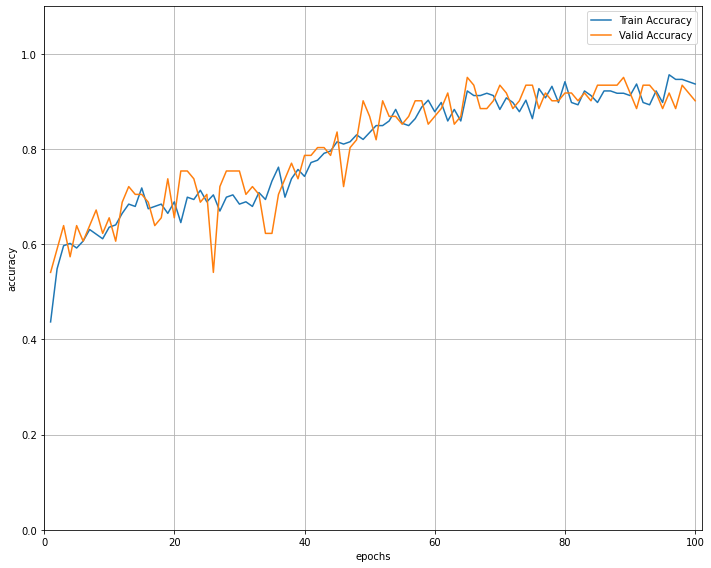

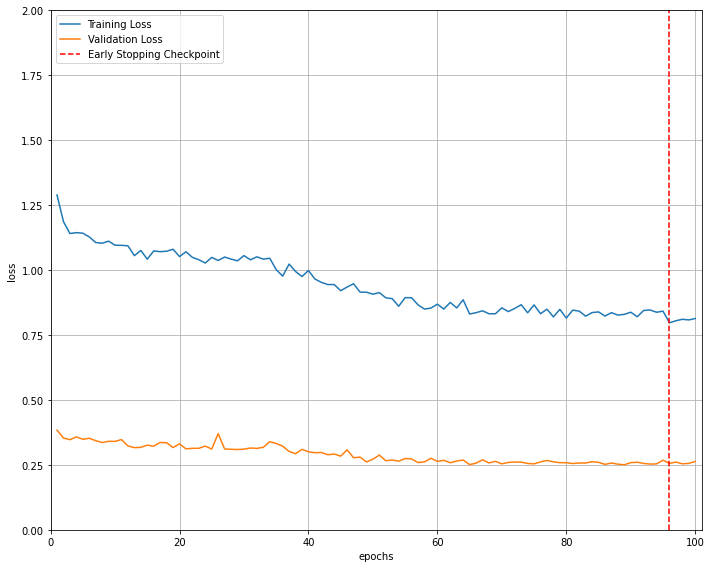

Confusion Matrix Without Normalization


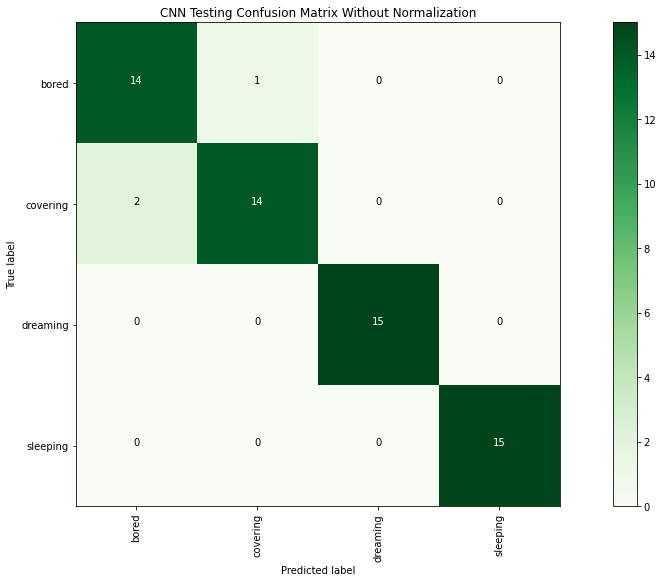

Normalized Confusion Matrix


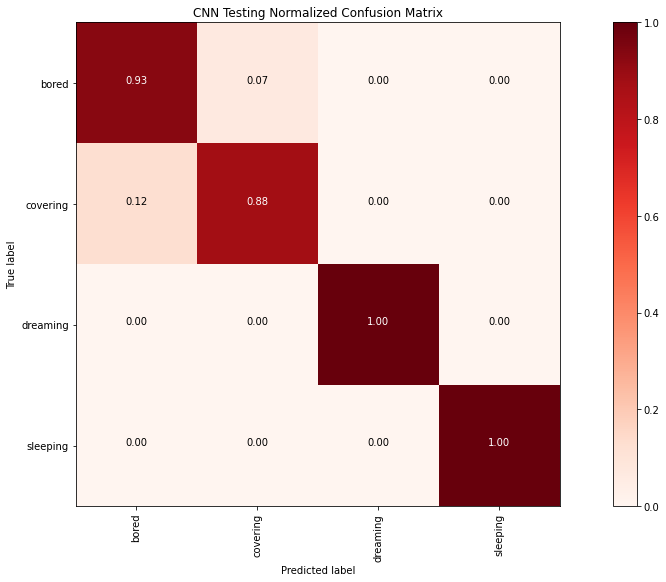

In [14]:
model = MyModel1(in_channels=3, n_classes=n_classes)
model.load_state_dict(torch.load("MyModel1.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))

activities = ["bored", "covering", "dreaming", "sleeping"]
plot_accuracy_per_epoch(train_accs, test_accs)
plot_avg_loss_per_epoch(train_losses, test_losses)
y_true, y_pred = tester(model, testloader)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, title='CNN Testing Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, normalize=True, title='CNN Testing Normalized Confusion Matrix')

In [15]:
accuracy_score(y_true, y_pred)

0.9508196721311475

In [16]:
class MyModel2(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(MyModel2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 8, 3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.pool4 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.pool5 = nn.MaxPool2d(2, 2)

        self.flat = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(4608, n_classes),
        )
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.pool4(x)

        x = self.conv5(x)
        x = self.pool5(x)

        x = self.flat(x)
        x = self.fc1(x)
        out = self.sm(x)
        return out

n_classes = 4
model = MyModel2(in_channels=3, n_classes=n_classes)
batch_image, batch_label = next(iter(trainloader))
batch_output = model(batch_image)
batch_output.shape, batch_label.shape

(torch.Size([8, 4]), torch.Size([8]))

In [17]:
train, test = get_image_paths()
trainloader = DataLoader(MyDataset(train, is_train=True), num_workers=2, batch_size=8, shuffle=True)
testloader = DataLoader(MyDataset(test, is_train=False), num_workers=2, batch_size=8, shuffle=True)

n_classes = 4
model = MyModel2(in_channels=3, n_classes=n_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
train_losses, test_losses, train_accs, test_accs = trainer(model, optimizer, criterion, trainloader, testloader, epochs=100, model_name="MyModel2.pth")

100%|██████████| 8/8 [00:00<00:00, 17.15it/s]


epoch=0 train loss=1.376692 test loss=0.420689 train accuracy=0.267 test accuracy=0.246


100%|██████████| 8/8 [00:00<00:00, 16.74it/s]


epoch=1 train loss=1.283588 test loss=0.382459 train accuracy=0.427 test accuracy=0.508


100%|██████████| 8/8 [00:00<00:00, 17.76it/s]


epoch=2 train loss=1.224318 test loss=0.372804 train accuracy=0.505 test accuracy=0.541


100%|██████████| 8/8 [00:00<00:00, 16.88it/s]


epoch=3 train loss=1.186072 test loss=0.366812 train accuracy=0.549 test accuracy=0.557


100%|██████████| 8/8 [00:00<00:00, 17.96it/s]


epoch=4 train loss=1.164404 test loss=0.353808 train accuracy=0.583 test accuracy=0.623


100%|██████████| 8/8 [00:00<00:00, 17.24it/s]


epoch=5 train loss=1.131519 test loss=0.355492 train accuracy=0.626 test accuracy=0.574


100%|██████████| 8/8 [00:00<00:00, 18.21it/s]


epoch=6 train loss=1.099747 test loss=0.342944 train accuracy=0.689 test accuracy=0.721


100%|██████████| 8/8 [00:00<00:00, 17.00it/s]


epoch=7 train loss=1.070009 test loss=0.343058 train accuracy=0.738 test accuracy=0.689


100%|██████████| 8/8 [00:00<00:00, 18.17it/s]


epoch=8 train loss=1.064102 test loss=0.333754 train accuracy=0.723 test accuracy=0.770


100%|██████████| 8/8 [00:00<00:00, 16.76it/s]


epoch=9 train loss=1.050899 test loss=0.319329 train accuracy=0.723 test accuracy=0.754


100%|██████████| 8/8 [00:00<00:00, 17.34it/s]


epoch=10 train loss=1.043278 test loss=0.313814 train accuracy=0.752 test accuracy=0.852


100%|██████████| 8/8 [00:00<00:00, 17.37it/s]


epoch=11 train loss=1.013901 test loss=0.308150 train accuracy=0.782 test accuracy=0.820


100%|██████████| 8/8 [00:00<00:00, 17.87it/s]


epoch=12 train loss=1.009058 test loss=0.298794 train accuracy=0.772 test accuracy=0.869


100%|██████████| 8/8 [00:00<00:00, 17.33it/s]


epoch=13 train loss=0.978033 test loss=0.291581 train accuracy=0.825 test accuracy=0.869


100%|██████████| 8/8 [00:00<00:00, 17.72it/s]


epoch=14 train loss=0.961229 test loss=0.296120 train accuracy=0.859 test accuracy=0.852


100%|██████████| 8/8 [00:00<00:00, 17.91it/s]


epoch=15 train loss=0.974212 test loss=0.291152 train accuracy=0.830 test accuracy=0.803


100%|██████████| 8/8 [00:00<00:00, 17.59it/s]


epoch=16 train loss=0.972571 test loss=0.285594 train accuracy=0.782 test accuracy=0.869


100%|██████████| 8/8 [00:00<00:00, 18.45it/s]


epoch=17 train loss=0.939599 test loss=0.277293 train accuracy=0.883 test accuracy=0.869


100%|██████████| 8/8 [00:00<00:00, 18.23it/s]


epoch=18 train loss=0.940727 test loss=0.275493 train accuracy=0.850 test accuracy=0.902


100%|██████████| 8/8 [00:00<00:00, 17.77it/s]


epoch=19 train loss=0.947784 test loss=0.273466 train accuracy=0.835 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 17.61it/s]


epoch=20 train loss=0.935666 test loss=0.282249 train accuracy=0.840 test accuracy=0.885


100%|██████████| 8/8 [00:00<00:00, 17.82it/s]


epoch=21 train loss=0.940145 test loss=0.273217 train accuracy=0.820 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 17.66it/s]


epoch=22 train loss=0.908543 test loss=0.272441 train accuracy=0.859 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 17.92it/s]


epoch=23 train loss=0.906699 test loss=0.271730 train accuracy=0.864 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.83it/s]


epoch=24 train loss=0.904431 test loss=0.268893 train accuracy=0.879 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.12it/s]


epoch=25 train loss=0.908492 test loss=0.270792 train accuracy=0.879 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 18.08it/s]


epoch=26 train loss=0.889007 test loss=0.274811 train accuracy=0.893 test accuracy=0.869


100%|██████████| 8/8 [00:00<00:00, 17.39it/s]


epoch=27 train loss=0.890129 test loss=0.264333 train accuracy=0.893 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 18.14it/s]


epoch=28 train loss=0.873628 test loss=0.261709 train accuracy=0.903 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.14it/s]


epoch=29 train loss=0.880524 test loss=0.267074 train accuracy=0.898 test accuracy=0.902


100%|██████████| 8/8 [00:00<00:00, 17.92it/s]


epoch=30 train loss=0.889414 test loss=0.259551 train accuracy=0.874 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.03it/s]


epoch=31 train loss=0.883031 test loss=0.269381 train accuracy=0.893 test accuracy=0.869


100%|██████████| 8/8 [00:00<00:00, 16.80it/s]


epoch=32 train loss=0.885390 test loss=0.264095 train accuracy=0.883 test accuracy=0.902


100%|██████████| 8/8 [00:00<00:00, 16.65it/s]


epoch=33 train loss=0.868359 test loss=0.262716 train accuracy=0.908 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 17.32it/s]


epoch=34 train loss=0.877058 test loss=0.265173 train accuracy=0.893 test accuracy=0.902


100%|██████████| 8/8 [00:00<00:00, 17.49it/s]


epoch=35 train loss=0.858883 test loss=0.256773 train accuracy=0.908 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.58it/s]


epoch=36 train loss=0.850892 test loss=0.259453 train accuracy=0.937 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 17.97it/s]


epoch=37 train loss=0.842066 test loss=0.257564 train accuracy=0.942 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.32it/s]


epoch=38 train loss=0.863797 test loss=0.258488 train accuracy=0.917 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 17.34it/s]


epoch=39 train loss=0.863748 test loss=0.254196 train accuracy=0.922 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.57it/s]


epoch=40 train loss=0.853350 test loss=0.259683 train accuracy=0.922 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 18.01it/s]


epoch=41 train loss=0.846220 test loss=0.255513 train accuracy=0.947 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.34it/s]


epoch=42 train loss=0.849373 test loss=0.254977 train accuracy=0.932 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.85it/s]


epoch=43 train loss=0.825480 test loss=0.253952 train accuracy=0.937 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 17.63it/s]


epoch=44 train loss=0.829131 test loss=0.250343 train accuracy=0.942 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.47it/s]


epoch=45 train loss=0.823215 test loss=0.248016 train accuracy=0.956 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.16it/s]


epoch=46 train loss=0.828088 test loss=0.249015 train accuracy=0.947 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.85it/s]


epoch=47 train loss=0.824558 test loss=0.248164 train accuracy=0.942 test accuracy=0.984


100%|██████████| 8/8 [00:00<00:00, 17.21it/s]


epoch=48 train loss=0.826869 test loss=0.247502 train accuracy=0.942 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.45it/s]


epoch=49 train loss=0.832165 test loss=0.251991 train accuracy=0.951 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 17.70it/s]


epoch=50 train loss=0.804836 test loss=0.249143 train accuracy=0.981 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.17it/s]


epoch=51 train loss=0.826176 test loss=0.256051 train accuracy=0.947 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 17.48it/s]


epoch=52 train loss=0.804676 test loss=0.250579 train accuracy=0.976 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 18.23it/s]


epoch=53 train loss=0.813503 test loss=0.251456 train accuracy=0.966 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.38it/s]


epoch=54 train loss=0.819367 test loss=0.247914 train accuracy=0.951 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.45it/s]


epoch=55 train loss=0.824337 test loss=0.253158 train accuracy=0.937 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 17.24it/s]


epoch=56 train loss=0.824555 test loss=0.257351 train accuracy=0.937 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 17.67it/s]


epoch=57 train loss=0.827419 test loss=0.252093 train accuracy=0.947 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.61it/s]


epoch=58 train loss=0.802949 test loss=0.245347 train accuracy=0.985 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.11it/s]


epoch=59 train loss=0.816222 test loss=0.253603 train accuracy=0.937 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 17.83it/s]


epoch=60 train loss=0.815563 test loss=0.246317 train accuracy=0.951 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.61it/s]


epoch=61 train loss=0.805089 test loss=0.245809 train accuracy=0.951 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.01it/s]


epoch=62 train loss=0.810849 test loss=0.250186 train accuracy=0.956 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.11it/s]


epoch=63 train loss=0.801009 test loss=0.246386 train accuracy=0.971 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.44it/s]


epoch=64 train loss=0.795345 test loss=0.245740 train accuracy=0.971 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.07it/s]


epoch=65 train loss=0.795155 test loss=0.249373 train accuracy=0.976 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.67it/s]


epoch=66 train loss=0.803025 test loss=0.247967 train accuracy=0.956 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.25it/s]


epoch=67 train loss=0.800538 test loss=0.250483 train accuracy=0.966 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.97it/s]


epoch=68 train loss=0.796018 test loss=0.247353 train accuracy=0.961 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.25it/s]


epoch=69 train loss=0.789409 test loss=0.243363 train accuracy=0.981 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.94it/s]


epoch=70 train loss=0.795666 test loss=0.242271 train accuracy=0.971 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.11it/s]


epoch=71 train loss=0.802657 test loss=0.245074 train accuracy=0.961 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.05it/s]


epoch=72 train loss=0.786335 test loss=0.244143 train accuracy=0.985 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.57it/s]


epoch=73 train loss=0.790891 test loss=0.246484 train accuracy=0.971 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 16.96it/s]


epoch=74 train loss=0.782465 test loss=0.247152 train accuracy=0.981 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.55it/s]


epoch=75 train loss=0.784235 test loss=0.247990 train accuracy=0.981 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.99it/s]


epoch=76 train loss=0.792430 test loss=0.247360 train accuracy=0.966 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.36it/s]


epoch=77 train loss=0.779598 test loss=0.249978 train accuracy=0.976 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.71it/s]


epoch=78 train loss=0.795150 test loss=0.247976 train accuracy=0.976 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.49it/s]


epoch=79 train loss=0.782857 test loss=0.246642 train accuracy=0.981 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.80it/s]


epoch=80 train loss=0.791153 test loss=0.245049 train accuracy=0.981 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.91it/s]


epoch=81 train loss=0.798452 test loss=0.245483 train accuracy=0.961 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.35it/s]


epoch=82 train loss=0.792397 test loss=0.242483 train accuracy=0.966 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.95it/s]


epoch=83 train loss=0.779640 test loss=0.245835 train accuracy=0.981 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.84it/s]


epoch=84 train loss=0.792183 test loss=0.242589 train accuracy=0.966 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.78it/s]


epoch=85 train loss=0.770586 test loss=0.242145 train accuracy=0.990 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 16.67it/s]


epoch=86 train loss=0.770769 test loss=0.243554 train accuracy=0.990 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.60it/s]


epoch=87 train loss=0.785320 test loss=0.242358 train accuracy=0.971 test accuracy=0.984


100%|██████████| 8/8 [00:00<00:00, 16.96it/s]


epoch=88 train loss=0.778974 test loss=0.242295 train accuracy=0.981 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.56it/s]


epoch=89 train loss=0.778127 test loss=0.242050 train accuracy=0.981 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 16.89it/s]


epoch=90 train loss=0.785534 test loss=0.240522 train accuracy=0.976 test accuracy=0.984


100%|██████████| 8/8 [00:00<00:00, 17.27it/s]


epoch=91 train loss=0.775215 test loss=0.242250 train accuracy=0.990 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.16it/s]


epoch=92 train loss=0.763814 test loss=0.243297 train accuracy=0.995 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.59it/s]


epoch=93 train loss=0.785846 test loss=0.245226 train accuracy=0.985 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.66it/s]


epoch=94 train loss=0.777379 test loss=0.242669 train accuracy=0.985 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.45it/s]


epoch=95 train loss=0.789181 test loss=0.243650 train accuracy=0.966 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 16.91it/s]


epoch=96 train loss=0.778541 test loss=0.251770 train accuracy=0.985 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.71it/s]


epoch=97 train loss=0.782100 test loss=0.249458 train accuracy=0.976 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 16.87it/s]


epoch=98 train loss=0.775974 test loss=0.251640 train accuracy=0.995 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.42it/s]

epoch=99 train loss=0.773623 test loss=0.242802 train accuracy=0.990 test accuracy=0.967


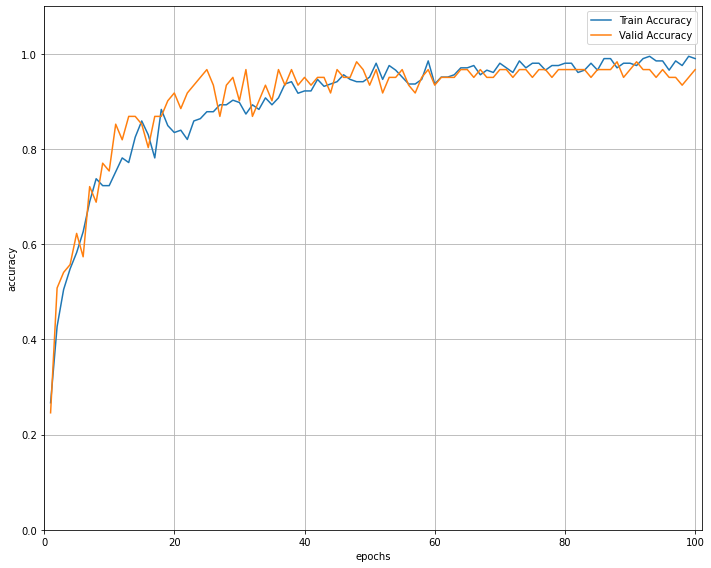

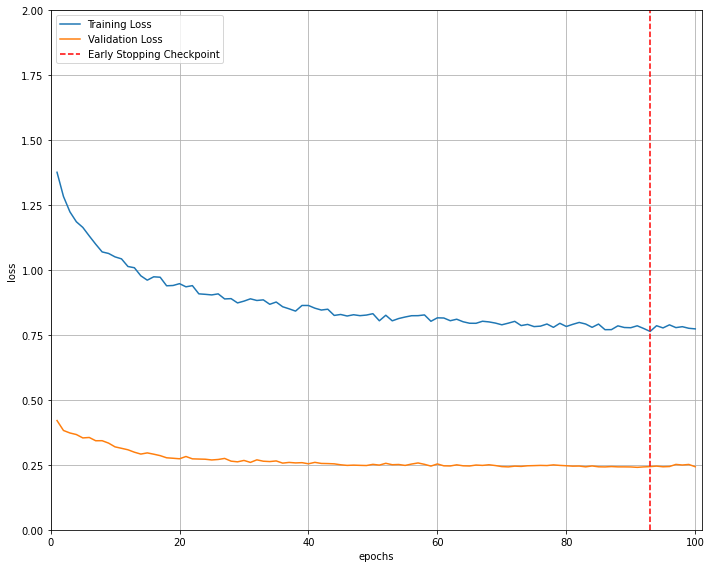

Confusion Matrix Without Normalization


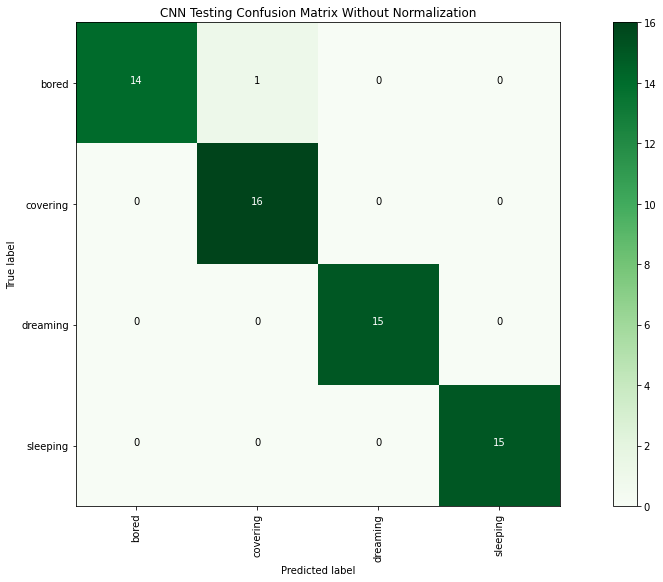

Normalized Confusion Matrix


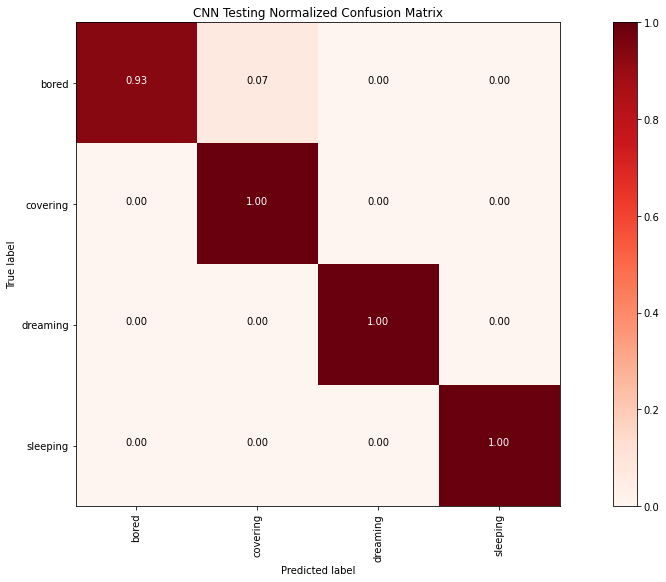

In [18]:
model = MyModel2(in_channels=3, n_classes=n_classes)
model.load_state_dict(torch.load("MyModel2.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))

activities = ["bored", "covering", "dreaming", "sleeping"]
plot_accuracy_per_epoch(train_accs, test_accs)
plot_avg_loss_per_epoch(train_losses, test_losses)
y_true, y_pred = tester(model, testloader)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, title='CNN Testing Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, normalize=True, title='CNN Testing Normalized Confusion Matrix')

In [19]:
accuracy_score(y_true, y_pred)

0.9836065573770492

In [20]:
class MyModel3(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(MyModel3, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.pool4 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.pool5 = nn.MaxPool2d(2, 2)

        self.flat = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(9216, n_classes),
        )
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.pool4(x)

        x = self.conv5(x)
        x = self.pool5(x)

        x = self.flat(x)
        x = self.fc1(x)
        out = self.sm(x)
        return out

n_classes = 4
model = MyModel3(in_channels=3, n_classes=n_classes)
batch_image, batch_label = next(iter(trainloader))
batch_output = model(batch_image)
batch_output.shape, batch_label.shape

(torch.Size([8, 4]), torch.Size([8]))

In [21]:
train, test = get_image_paths()
trainloader = DataLoader(MyDataset(train, is_train=True), num_workers=2, batch_size=8, shuffle=True)
testloader = DataLoader(MyDataset(test, is_train=False), num_workers=2, batch_size=8, shuffle=True)

n_classes = 4
model = MyModel3(in_channels=3, n_classes=n_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
train_losses, test_losses, train_accs, test_accs = trainer(model, optimizer, criterion, trainloader, testloader, epochs=100, model_name="MyModel3.pth")

100%|██████████| 8/8 [00:00<00:00, 16.05it/s]


epoch=0 train loss=1.363134 test loss=0.417385 train accuracy=0.311 test accuracy=0.344


100%|██████████| 8/8 [00:00<00:00, 16.52it/s]


epoch=1 train loss=1.187797 test loss=0.375962 train accuracy=0.558 test accuracy=0.426


100%|██████████| 8/8 [00:00<00:00, 16.77it/s]


epoch=2 train loss=1.104538 test loss=0.329652 train accuracy=0.650 test accuracy=0.754


100%|██████████| 8/8 [00:00<00:00, 16.75it/s]


epoch=3 train loss=1.048107 test loss=0.324999 train accuracy=0.752 test accuracy=0.721


100%|██████████| 8/8 [00:00<00:00, 17.05it/s]


epoch=4 train loss=1.052395 test loss=0.318977 train accuracy=0.723 test accuracy=0.721


100%|██████████| 8/8 [00:00<00:00, 16.41it/s]


epoch=5 train loss=1.013207 test loss=0.309238 train accuracy=0.738 test accuracy=0.787


100%|██████████| 8/8 [00:00<00:00, 16.85it/s]


epoch=6 train loss=1.001257 test loss=0.308040 train accuracy=0.782 test accuracy=0.787


100%|██████████| 8/8 [00:00<00:00, 17.35it/s]


epoch=7 train loss=0.988706 test loss=0.296733 train accuracy=0.767 test accuracy=0.787


100%|██████████| 8/8 [00:00<00:00, 16.76it/s]


epoch=8 train loss=0.953514 test loss=0.287773 train accuracy=0.801 test accuracy=0.820


100%|██████████| 8/8 [00:00<00:00, 16.82it/s]


epoch=9 train loss=0.943051 test loss=0.278210 train accuracy=0.820 test accuracy=0.902


100%|██████████| 8/8 [00:00<00:00, 16.44it/s]


epoch=10 train loss=0.959280 test loss=0.301470 train accuracy=0.786 test accuracy=0.770


100%|██████████| 8/8 [00:00<00:00, 17.23it/s]


epoch=11 train loss=0.942300 test loss=0.280535 train accuracy=0.811 test accuracy=0.836


100%|██████████| 8/8 [00:00<00:00, 17.37it/s]


epoch=12 train loss=0.916658 test loss=0.293771 train accuracy=0.840 test accuracy=0.820


100%|██████████| 8/8 [00:00<00:00, 17.55it/s]


epoch=13 train loss=0.901726 test loss=0.278383 train accuracy=0.864 test accuracy=0.852


100%|██████████| 8/8 [00:00<00:00, 17.07it/s]


epoch=14 train loss=0.882762 test loss=0.276297 train accuracy=0.893 test accuracy=0.852


100%|██████████| 8/8 [00:00<00:00, 17.00it/s]


epoch=15 train loss=0.895022 test loss=0.265468 train accuracy=0.879 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 16.91it/s]


epoch=16 train loss=0.886248 test loss=0.271988 train accuracy=0.888 test accuracy=0.869


100%|██████████| 8/8 [00:00<00:00, 17.05it/s]


epoch=17 train loss=0.891823 test loss=0.275652 train accuracy=0.869 test accuracy=0.852


100%|██████████| 8/8 [00:00<00:00, 17.45it/s]


epoch=18 train loss=0.861244 test loss=0.265804 train accuracy=0.888 test accuracy=0.902


100%|██████████| 8/8 [00:00<00:00, 16.56it/s]


epoch=19 train loss=0.856069 test loss=0.263953 train accuracy=0.908 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 17.47it/s]


epoch=20 train loss=0.864386 test loss=0.280824 train accuracy=0.908 test accuracy=0.836


100%|██████████| 8/8 [00:00<00:00, 16.66it/s]


epoch=21 train loss=0.852529 test loss=0.265387 train accuracy=0.908 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 17.25it/s]


epoch=22 train loss=0.846723 test loss=0.266452 train accuracy=0.908 test accuracy=0.885


100%|██████████| 8/8 [00:00<00:00, 17.06it/s]


epoch=23 train loss=0.854074 test loss=0.277069 train accuracy=0.903 test accuracy=0.869


100%|██████████| 8/8 [00:00<00:00, 16.41it/s]


epoch=24 train loss=0.845465 test loss=0.278383 train accuracy=0.913 test accuracy=0.852


100%|██████████| 8/8 [00:00<00:00, 17.34it/s]


epoch=25 train loss=0.824566 test loss=0.268795 train accuracy=0.932 test accuracy=0.902


100%|██████████| 8/8 [00:00<00:00, 16.45it/s]


epoch=26 train loss=0.821041 test loss=0.272294 train accuracy=0.947 test accuracy=0.902


100%|██████████| 8/8 [00:00<00:00, 16.47it/s]


epoch=27 train loss=0.842287 test loss=0.277255 train accuracy=0.922 test accuracy=0.852


100%|██████████| 8/8 [00:00<00:00, 17.15it/s]


epoch=28 train loss=0.829342 test loss=0.270737 train accuracy=0.951 test accuracy=0.869


100%|██████████| 8/8 [00:00<00:00, 16.90it/s]


epoch=29 train loss=0.817275 test loss=0.279358 train accuracy=0.942 test accuracy=0.803


100%|██████████| 8/8 [00:00<00:00, 16.73it/s]


epoch=30 train loss=0.831568 test loss=0.254812 train accuracy=0.917 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.32it/s]


epoch=31 train loss=0.825227 test loss=0.254262 train accuracy=0.927 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.46it/s]


epoch=32 train loss=0.814425 test loss=0.260763 train accuracy=0.947 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 16.97it/s]


epoch=33 train loss=0.820393 test loss=0.258267 train accuracy=0.942 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.07it/s]


epoch=34 train loss=0.819721 test loss=0.254709 train accuracy=0.947 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.08it/s]


epoch=35 train loss=0.799423 test loss=0.252301 train accuracy=0.961 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.10it/s]


epoch=36 train loss=0.796948 test loss=0.249486 train accuracy=0.961 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.31it/s]


epoch=37 train loss=0.804295 test loss=0.256996 train accuracy=0.966 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 17.24it/s]


epoch=38 train loss=0.813769 test loss=0.250780 train accuracy=0.942 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 16.98it/s]


epoch=39 train loss=0.794770 test loss=0.267581 train accuracy=0.971 test accuracy=0.885


100%|██████████| 8/8 [00:00<00:00, 17.13it/s]


epoch=40 train loss=0.817572 test loss=0.248120 train accuracy=0.932 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.24it/s]


epoch=41 train loss=0.787943 test loss=0.259264 train accuracy=0.976 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 16.74it/s]


epoch=42 train loss=0.811584 test loss=0.258266 train accuracy=0.942 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 17.23it/s]


epoch=43 train loss=0.795223 test loss=0.253740 train accuracy=0.966 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 17.04it/s]


epoch=44 train loss=0.787563 test loss=0.250426 train accuracy=0.981 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 16.81it/s]


epoch=45 train loss=0.789020 test loss=0.257239 train accuracy=0.966 test accuracy=0.885


100%|██████████| 8/8 [00:00<00:00, 17.34it/s]


epoch=46 train loss=0.790295 test loss=0.251038 train accuracy=0.966 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 16.81it/s]


epoch=47 train loss=0.784793 test loss=0.255905 train accuracy=0.981 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 16.96it/s]


epoch=48 train loss=0.782415 test loss=0.259647 train accuracy=0.976 test accuracy=0.902


100%|██████████| 8/8 [00:00<00:00, 16.24it/s]


epoch=49 train loss=0.778648 test loss=0.249854 train accuracy=0.981 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 16.44it/s]


epoch=50 train loss=0.782998 test loss=0.267866 train accuracy=0.985 test accuracy=0.902


100%|██████████| 8/8 [00:00<00:00, 17.28it/s]


epoch=51 train loss=0.793163 test loss=0.256831 train accuracy=0.956 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 16.66it/s]


epoch=52 train loss=0.785145 test loss=0.246955 train accuracy=0.971 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 16.85it/s]


epoch=53 train loss=0.779909 test loss=0.251678 train accuracy=0.976 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 16.39it/s]


epoch=54 train loss=0.776404 test loss=0.245249 train accuracy=0.985 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.51it/s]


epoch=55 train loss=0.765960 test loss=0.244839 train accuracy=0.990 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.46it/s]


epoch=56 train loss=0.765029 test loss=0.245597 train accuracy=0.990 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.26it/s]


epoch=57 train loss=0.773745 test loss=0.251416 train accuracy=0.981 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 16.26it/s]


epoch=58 train loss=0.784309 test loss=0.251997 train accuracy=0.956 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 17.57it/s]


epoch=59 train loss=0.777276 test loss=0.249223 train accuracy=0.981 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 16.15it/s]


epoch=60 train loss=0.772442 test loss=0.245216 train accuracy=0.990 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.16it/s]


epoch=61 train loss=0.764087 test loss=0.251579 train accuracy=0.990 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 16.39it/s]


epoch=62 train loss=0.772202 test loss=0.257753 train accuracy=0.990 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 16.98it/s]


epoch=63 train loss=0.772584 test loss=0.241688 train accuracy=0.971 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.17it/s]


epoch=64 train loss=0.770463 test loss=0.246568 train accuracy=0.976 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.44it/s]


epoch=65 train loss=0.770891 test loss=0.244069 train accuracy=0.985 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 16.48it/s]


epoch=66 train loss=0.778931 test loss=0.248315 train accuracy=0.976 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 17.01it/s]


epoch=67 train loss=0.788896 test loss=0.238772 train accuracy=0.956 test accuracy=0.984


100%|██████████| 8/8 [00:00<00:00, 17.11it/s]


epoch=68 train loss=0.780677 test loss=0.242510 train accuracy=0.966 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.59it/s]


epoch=69 train loss=0.772014 test loss=0.245819 train accuracy=0.976 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.21it/s]


epoch=70 train loss=0.786674 test loss=0.256651 train accuracy=0.951 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 16.33it/s]


epoch=71 train loss=0.787814 test loss=0.250825 train accuracy=0.971 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 17.35it/s]


epoch=72 train loss=0.777045 test loss=0.238236 train accuracy=0.981 test accuracy=0.984


100%|██████████| 8/8 [00:00<00:00, 17.43it/s]


epoch=73 train loss=0.781438 test loss=0.265199 train accuracy=0.976 test accuracy=0.885


100%|██████████| 8/8 [00:00<00:00, 17.02it/s]


epoch=74 train loss=0.791314 test loss=0.251691 train accuracy=0.966 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 16.25it/s]


epoch=75 train loss=0.771805 test loss=0.248925 train accuracy=0.990 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 16.75it/s]


epoch=76 train loss=0.783002 test loss=0.248560 train accuracy=0.961 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 17.20it/s]


epoch=77 train loss=0.771222 test loss=0.260110 train accuracy=0.981 test accuracy=0.869


100%|██████████| 8/8 [00:00<00:00, 17.17it/s]


epoch=78 train loss=0.778815 test loss=0.246722 train accuracy=0.976 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 16.86it/s]


epoch=79 train loss=0.772460 test loss=0.246366 train accuracy=0.981 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.39it/s]


epoch=80 train loss=0.765081 test loss=0.245636 train accuracy=0.985 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 16.75it/s]


epoch=81 train loss=0.763188 test loss=0.243590 train accuracy=0.995 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.15it/s]


epoch=82 train loss=0.765954 test loss=0.242097 train accuracy=0.990 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.17it/s]


epoch=83 train loss=0.751170 test loss=0.245222 train accuracy=1.000 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.28it/s]


epoch=84 train loss=0.751858 test loss=0.241421 train accuracy=1.000 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 16.84it/s]


epoch=85 train loss=0.763295 test loss=0.250981 train accuracy=0.990 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 17.32it/s]


epoch=86 train loss=0.791025 test loss=0.252048 train accuracy=0.956 test accuracy=0.918


100%|██████████| 8/8 [00:00<00:00, 16.39it/s]


epoch=87 train loss=0.769053 test loss=0.241347 train accuracy=0.981 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 16.96it/s]


epoch=88 train loss=0.776237 test loss=0.239799 train accuracy=0.990 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 16.25it/s]


epoch=89 train loss=0.782503 test loss=0.245176 train accuracy=0.966 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.57it/s]


epoch=90 train loss=0.759435 test loss=0.242403 train accuracy=1.000 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 16.54it/s]


epoch=91 train loss=0.772122 test loss=0.247118 train accuracy=0.981 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 16.65it/s]


epoch=92 train loss=0.766047 test loss=0.251464 train accuracy=0.985 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 16.98it/s]


epoch=93 train loss=0.768412 test loss=0.251040 train accuracy=0.985 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.08it/s]


epoch=94 train loss=0.761403 test loss=0.248330 train accuracy=0.990 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 17.19it/s]


epoch=95 train loss=0.754396 test loss=0.243901 train accuracy=1.000 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 16.67it/s]


epoch=96 train loss=0.765818 test loss=0.240175 train accuracy=0.985 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 16.50it/s]


epoch=97 train loss=0.760560 test loss=0.248743 train accuracy=0.990 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 16.89it/s]


epoch=98 train loss=0.765970 test loss=0.243023 train accuracy=0.985 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 17.31it/s]

epoch=99 train loss=0.765544 test loss=0.244005 train accuracy=0.981 test accuracy=0.967


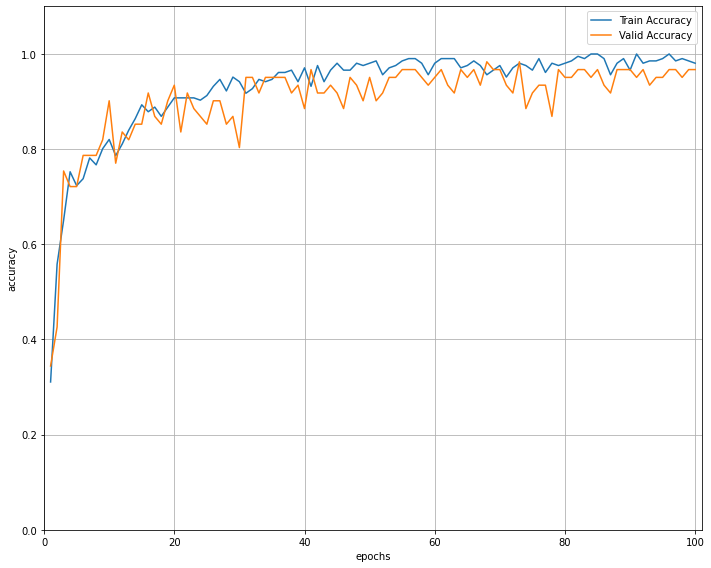

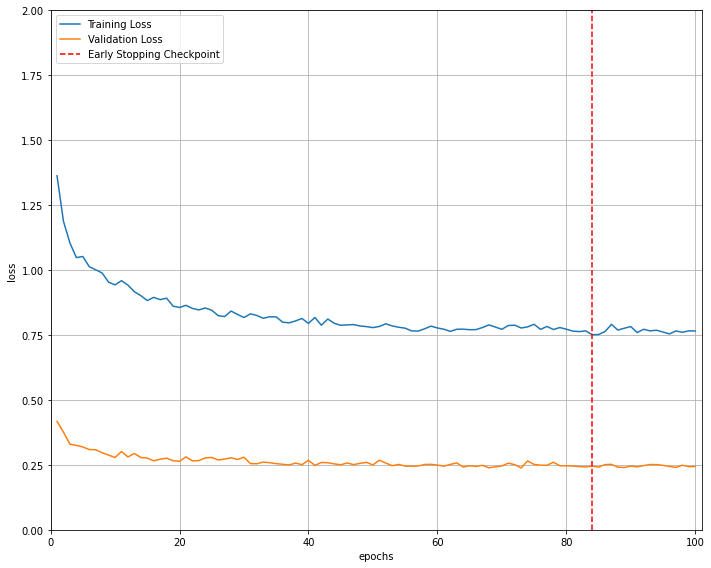

Confusion Matrix Without Normalization


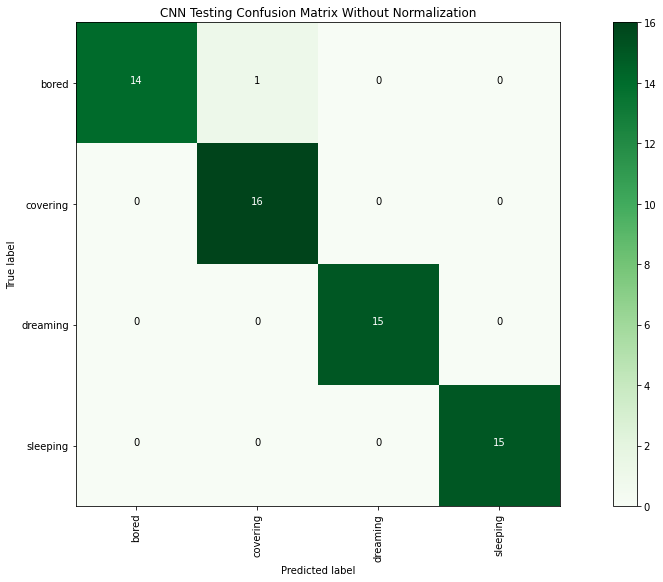

Normalized Confusion Matrix


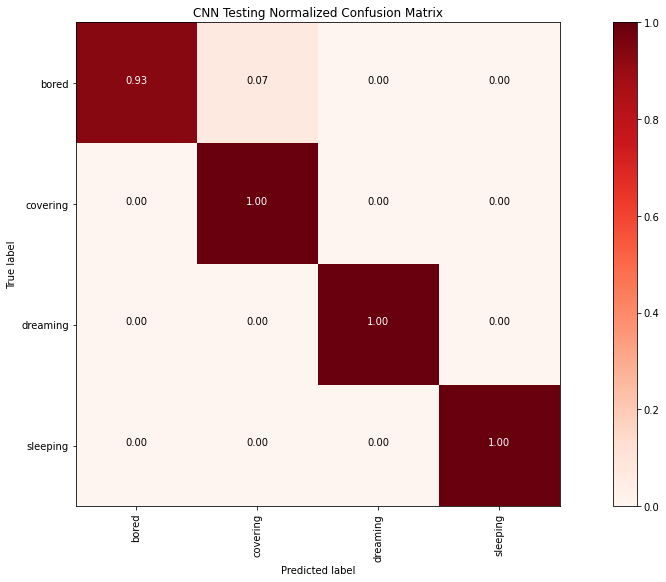

In [22]:
model = MyModel3(in_channels=3, n_classes=n_classes)
model.load_state_dict(torch.load("MyModel3.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))

activities = ["bored", "covering", "dreaming", "sleeping"]
plot_accuracy_per_epoch(train_accs, test_accs)
plot_avg_loss_per_epoch(train_losses, test_losses)
y_true, y_pred = tester(model, testloader)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, title='CNN Testing Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, normalize=True, title='CNN Testing Normalized Confusion Matrix')

In [23]:
accuracy_score(y_true, y_pred)

0.9836065573770492

In [24]:
class MyModel4(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(MyModel4, self).__init__()
        pretrained = models.resnet18(pretrained=True)
        self.pretrained = nn.Sequential(*list(pretrained.children())[:-1])
        self.flat = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(512, n_classes),
        )
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pretrained(x)
        x = self.flat(x)
        x = self.fc1(x)
        out = self.sm(x)
        return out

n_classes = 4
model = MyModel4(in_channels=3, n_classes=n_classes)
batch_image, batch_label = next(iter(trainloader))
batch_output = model(batch_image)
batch_output.shape, batch_label.shape

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

(torch.Size([8, 4]), torch.Size([8]))

In [25]:
train, test = get_image_paths()
trainloader = DataLoader(MyDataset(train, is_train=True), num_workers=2, batch_size=8, shuffle=True)
testloader = DataLoader(MyDataset(test, is_train=False), num_workers=2, batch_size=8, shuffle=True)

n_classes = 4
model = MyModel4(in_channels=3, n_classes=n_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
train_losses, test_losses, train_accs, test_accs = trainer(model, optimizer, criterion, trainloader, testloader, epochs=100, model_name="MyModel4.pth")

100%|██████████| 8/8 [00:00<00:00, 16.57it/s]


epoch=0 train loss=1.133660 test loss=0.285076 train accuracy=0.748 test accuracy=0.836


100%|██████████| 8/8 [00:00<00:00, 15.58it/s]


epoch=1 train loss=0.888003 test loss=0.243464 train accuracy=0.903 test accuracy=0.984


100%|██████████| 8/8 [00:00<00:00, 15.90it/s]


epoch=2 train loss=0.814016 test loss=0.250620 train accuracy=0.956 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 16.34it/s]


epoch=3 train loss=0.808052 test loss=0.253676 train accuracy=0.956 test accuracy=0.934


100%|██████████| 8/8 [00:00<00:00, 16.23it/s]


epoch=4 train loss=0.805717 test loss=0.239310 train accuracy=0.951 test accuracy=0.984


100%|██████████| 8/8 [00:00<00:00, 16.04it/s]


epoch=5 train loss=0.818899 test loss=0.235109 train accuracy=0.932 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.18it/s]


epoch=6 train loss=0.784415 test loss=0.236610 train accuracy=0.985 test accuracy=0.984


100%|██████████| 8/8 [00:00<00:00, 15.91it/s]


epoch=7 train loss=0.793928 test loss=0.230099 train accuracy=0.961 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.15it/s]


epoch=8 train loss=0.796035 test loss=0.229579 train accuracy=0.951 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.95it/s]


epoch=9 train loss=0.778080 test loss=0.230207 train accuracy=0.971 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.00it/s]


epoch=10 train loss=0.767428 test loss=0.238352 train accuracy=0.985 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 15.63it/s]


epoch=11 train loss=0.772208 test loss=0.233453 train accuracy=0.981 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.22it/s]


epoch=12 train loss=0.778665 test loss=0.241687 train accuracy=0.976 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 15.75it/s]


epoch=13 train loss=0.775304 test loss=0.239331 train accuracy=0.971 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 15.74it/s]


epoch=14 train loss=0.767860 test loss=0.236723 train accuracy=0.985 test accuracy=0.984


100%|██████████| 8/8 [00:00<00:00, 15.27it/s]


epoch=15 train loss=0.773807 test loss=0.233703 train accuracy=0.976 test accuracy=0.984


100%|██████████| 8/8 [00:00<00:00, 15.90it/s]


epoch=16 train loss=0.751684 test loss=0.232656 train accuracy=1.000 test accuracy=0.984


100%|██████████| 8/8 [00:00<00:00, 16.43it/s]


epoch=17 train loss=0.773156 test loss=0.243798 train accuracy=0.981 test accuracy=0.951


100%|██████████| 8/8 [00:00<00:00, 16.34it/s]


epoch=18 train loss=0.754693 test loss=0.237428 train accuracy=1.000 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 15.60it/s]


epoch=19 train loss=0.758241 test loss=0.232652 train accuracy=0.995 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.00it/s]


epoch=20 train loss=0.751083 test loss=0.231375 train accuracy=0.995 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.00it/s]


epoch=21 train loss=0.750445 test loss=0.231833 train accuracy=0.995 test accuracy=0.984


100%|██████████| 8/8 [00:00<00:00, 16.29it/s]


epoch=22 train loss=0.749029 test loss=0.232790 train accuracy=1.000 test accuracy=0.984


100%|██████████| 8/8 [00:00<00:00, 16.95it/s]


epoch=23 train loss=0.749305 test loss=0.230710 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.18it/s]


epoch=24 train loss=0.766685 test loss=0.229291 train accuracy=0.990 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.38it/s]


epoch=25 train loss=0.755697 test loss=0.229882 train accuracy=0.995 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.25it/s]


epoch=26 train loss=0.748436 test loss=0.231144 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.98it/s]


epoch=27 train loss=0.754119 test loss=0.234080 train accuracy=0.995 test accuracy=0.984


100%|██████████| 8/8 [00:00<00:00, 15.59it/s]


epoch=28 train loss=0.746293 test loss=0.231213 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 14.47it/s]


epoch=29 train loss=0.751883 test loss=0.230623 train accuracy=0.995 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.10it/s]


epoch=30 train loss=0.747325 test loss=0.230223 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.21it/s]


epoch=31 train loss=0.759983 test loss=0.228983 train accuracy=0.990 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.25it/s]


epoch=32 train loss=0.746839 test loss=0.229922 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.49it/s]


epoch=33 train loss=0.766361 test loss=0.229053 train accuracy=0.985 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.59it/s]


epoch=34 train loss=0.766730 test loss=0.231007 train accuracy=0.985 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.51it/s]


epoch=35 train loss=0.764758 test loss=0.239166 train accuracy=0.981 test accuracy=0.967


100%|██████████| 8/8 [00:00<00:00, 16.09it/s]


epoch=36 train loss=0.750526 test loss=0.234479 train accuracy=1.000 test accuracy=0.984


100%|██████████| 8/8 [00:00<00:00, 16.01it/s]


epoch=37 train loss=0.758395 test loss=0.234105 train accuracy=0.995 test accuracy=0.984


100%|██████████| 8/8 [00:00<00:00, 16.40it/s]


epoch=38 train loss=0.746968 test loss=0.230429 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.95it/s]


epoch=39 train loss=0.755739 test loss=0.230171 train accuracy=0.990 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.34it/s]


epoch=40 train loss=0.751558 test loss=0.229434 train accuracy=0.995 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.52it/s]


epoch=41 train loss=0.761159 test loss=0.229460 train accuracy=0.985 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.63it/s]


epoch=42 train loss=0.752011 test loss=0.229144 train accuracy=0.995 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.26it/s]


epoch=43 train loss=0.750906 test loss=0.228915 train accuracy=0.995 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.91it/s]


epoch=44 train loss=0.747146 test loss=0.228996 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.98it/s]


epoch=45 train loss=0.748146 test loss=0.229031 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.99it/s]


epoch=46 train loss=0.756798 test loss=0.228892 train accuracy=0.995 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.29it/s]


epoch=47 train loss=0.749883 test loss=0.228929 train accuracy=0.995 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.03it/s]


epoch=48 train loss=0.750272 test loss=0.229269 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.66it/s]


epoch=49 train loss=0.748571 test loss=0.228994 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.20it/s]


epoch=50 train loss=0.747665 test loss=0.228972 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.04it/s]


epoch=51 train loss=0.750706 test loss=0.229058 train accuracy=0.995 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.95it/s]


epoch=52 train loss=0.746030 test loss=0.229051 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.85it/s]


epoch=53 train loss=0.749762 test loss=0.228873 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.54it/s]


epoch=54 train loss=0.747266 test loss=0.228929 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.52it/s]


epoch=55 train loss=0.745417 test loss=0.228903 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.62it/s]


epoch=56 train loss=0.745156 test loss=0.228882 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.38it/s]


epoch=57 train loss=0.745219 test loss=0.228862 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.29it/s]


epoch=58 train loss=0.754203 test loss=0.230857 train accuracy=0.990 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.00it/s]


epoch=59 train loss=0.750295 test loss=0.228945 train accuracy=0.995 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.98it/s]


epoch=60 train loss=0.754732 test loss=0.229144 train accuracy=0.995 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.56it/s]


epoch=61 train loss=0.747115 test loss=0.230149 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.23it/s]


epoch=62 train loss=0.748474 test loss=0.229214 train accuracy=0.995 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.40it/s]


epoch=63 train loss=0.748660 test loss=0.229327 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.23it/s]


epoch=64 train loss=0.746190 test loss=0.229392 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.45it/s]


epoch=65 train loss=0.755073 test loss=0.229011 train accuracy=0.990 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.53it/s]


epoch=66 train loss=0.749752 test loss=0.228877 train accuracy=0.995 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.95it/s]


epoch=67 train loss=0.746673 test loss=0.228930 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.08it/s]


epoch=68 train loss=0.745300 test loss=0.229039 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.16it/s]


epoch=69 train loss=0.763787 test loss=0.229164 train accuracy=0.985 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.42it/s]


epoch=70 train loss=0.759044 test loss=0.230410 train accuracy=0.990 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.01it/s]


epoch=71 train loss=0.751822 test loss=0.228919 train accuracy=0.995 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.55it/s]


epoch=72 train loss=0.750950 test loss=0.229069 train accuracy=0.995 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.66it/s]


epoch=73 train loss=0.751218 test loss=0.232185 train accuracy=0.990 test accuracy=0.984


100%|██████████| 8/8 [00:00<00:00, 15.43it/s]


epoch=74 train loss=0.749233 test loss=0.230679 train accuracy=0.995 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.11it/s]


epoch=75 train loss=0.746307 test loss=0.229351 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.98it/s]


epoch=76 train loss=0.745137 test loss=0.229050 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.20it/s]


epoch=77 train loss=0.744178 test loss=0.229041 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.46it/s]


epoch=78 train loss=0.745528 test loss=0.228922 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.63it/s]


epoch=79 train loss=0.744209 test loss=0.228926 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.27it/s]


epoch=80 train loss=0.745141 test loss=0.229005 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.26it/s]


epoch=81 train loss=0.744321 test loss=0.228969 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.55it/s]


epoch=82 train loss=0.744556 test loss=0.228879 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.44it/s]


epoch=83 train loss=0.744181 test loss=0.228879 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.28it/s]


epoch=84 train loss=0.744193 test loss=0.228900 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.26it/s]


epoch=85 train loss=0.744174 test loss=0.228884 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.62it/s]


epoch=86 train loss=0.744895 test loss=0.228864 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.87it/s]


epoch=87 train loss=0.744739 test loss=0.228874 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.21it/s]


epoch=88 train loss=0.758502 test loss=0.228861 train accuracy=0.990 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.67it/s]


epoch=89 train loss=0.747675 test loss=0.229699 train accuracy=0.995 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.01it/s]


epoch=90 train loss=0.744936 test loss=0.228919 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.76it/s]


epoch=91 train loss=0.745130 test loss=0.228890 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.27it/s]


epoch=92 train loss=0.748606 test loss=0.228935 train accuracy=0.995 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.11it/s]


epoch=93 train loss=0.746592 test loss=0.229220 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.66it/s]


epoch=94 train loss=0.745839 test loss=0.229109 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 16.67it/s]


epoch=95 train loss=0.749149 test loss=0.228947 train accuracy=0.995 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.15it/s]


epoch=96 train loss=0.748963 test loss=0.229057 train accuracy=0.995 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.37it/s]


epoch=97 train loss=0.747167 test loss=0.229140 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.85it/s]


epoch=98 train loss=0.744880 test loss=0.229022 train accuracy=1.000 test accuracy=1.000


100%|██████████| 8/8 [00:00<00:00, 15.54it/s]

epoch=99 train loss=0.744462 test loss=0.228920 train accuracy=1.000 test accuracy=1.000


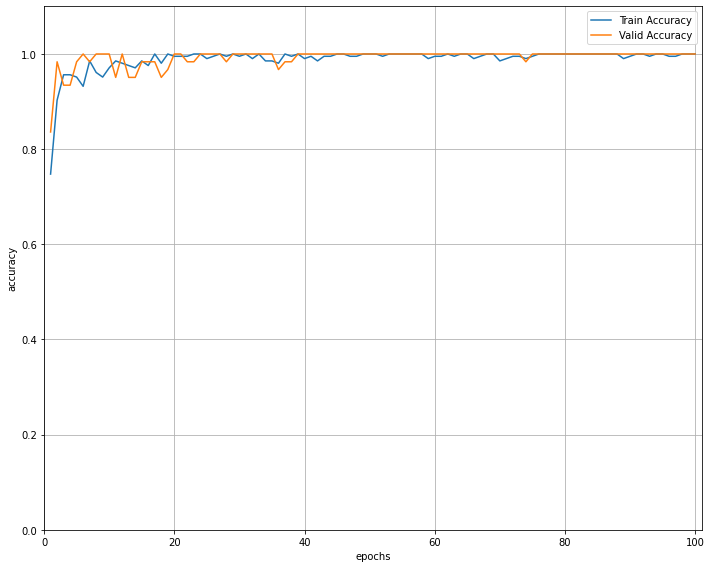

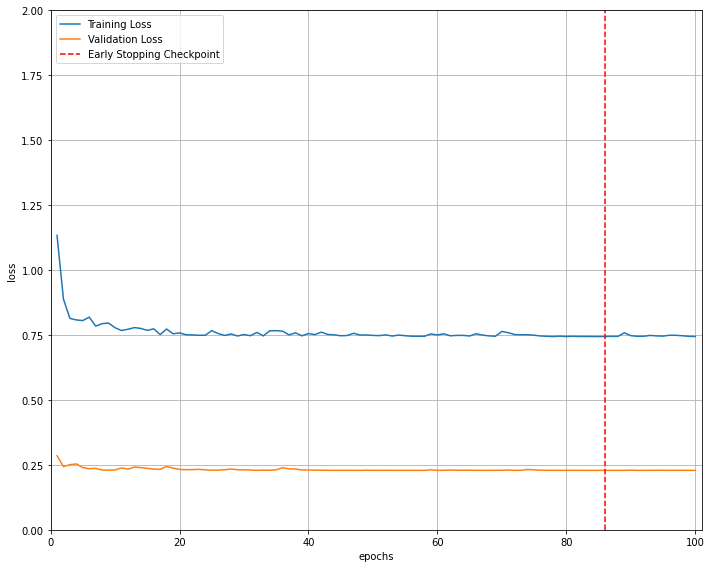

Confusion Matrix Without Normalization


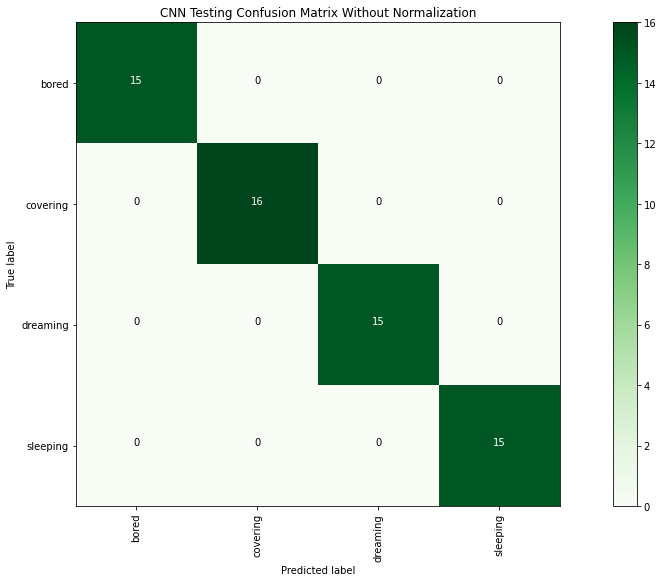

Normalized Confusion Matrix


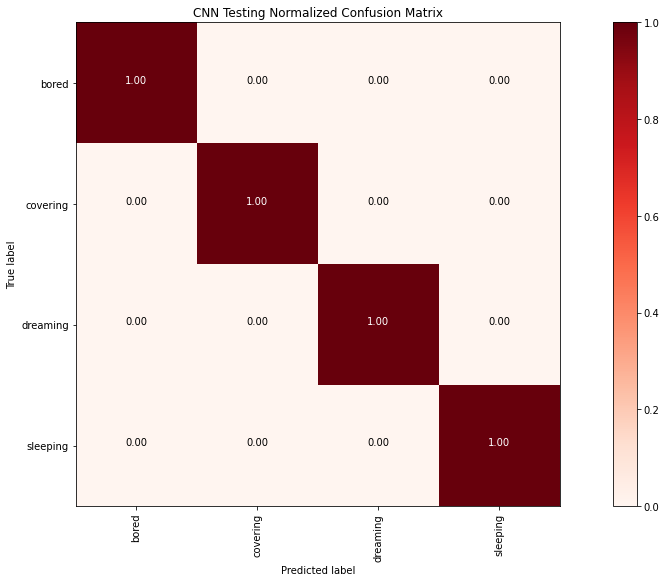

In [26]:
model = MyModel4(in_channels=3, n_classes=n_classes)
model.load_state_dict(torch.load("MyModel4.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))

activities = ["bored", "covering", "dreaming", "sleeping"]
plot_accuracy_per_epoch(train_accs, test_accs)
plot_avg_loss_per_epoch(train_losses, test_losses)
y_true, y_pred = tester(model, testloader)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, title='CNN Testing Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, normalize=True, title='CNN Testing Normalized Confusion Matrix')

In [27]:
accuracy_score(y_true, y_pred)

1.0